In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss, train_NN, loadCIFAR10, plot_loss, plot_acc, plot_shifts

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [3]:
batch_size = 100
input_shape = (batch_size, 3, 32, 32)
num_labels = 10

train_dataset, train_dataloader, test_dataset, test_dataloader, classes = loadCIFAR10(batch_size)

Files already downloaded and verified
Files already downloaded and verified


## CIFAR10 LeNet

In [4]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeNet_optimizer.pkl', 'rb') as file:
    LeNet_optim = pickle.load(file)

parameters, acc= LeNet_optim.get_best_parameters()
print(parameters, acc)

{'lr': 0.09375, 'momentum': 0.65625, 'p_randomTransform': 0.3125} 69.994


In [5]:
from Models import LeNet

LeNN = LeNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Conv2d: 2-5                       [100, 16, 16, 16]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 16, 16]         32
│    └─Tanh: 2-7                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-8                    [100, 16, 8, 8]           --
│    └─Flatten: 2-9                      [100, 1024]               --
│    └─Linear: 2-10                      [100, 120]                123,000
│    └─Tanh: 2-11                        [100, 120]                --
│    └

In [6]:
PATH = "models/LeNet_Cifar/LeNet.pth"

if exists(PATH):
    LeNN = torch.load(PATH)
    LeNN.eval()

In [7]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.928
test_loss: 1.805, test_accuracy: 35.54
[1,   200] train_loss: 1.745
test_loss: 1.651, test_accuracy: 41.89
[1,   300] train_loss: 1.648
test_loss: 1.617, test_accuracy: 42.73
[1,   400] train_loss: 1.549
test_loss: 1.467, test_accuracy: 47.14
[1,   500] train_loss: 1.517
test_loss: 1.430, test_accuracy: 48.32
[2,   100] train_loss: 1.428
test_loss: 1.393, test_accuracy: 49.71
[2,   200] train_loss: 1.415
test_loss: 1.367, test_accuracy: 50.85
[2,   300] train_loss: 1.385
test_loss: 1.351, test_accuracy: 51.79
[2,   400] train_loss: 1.365
test_loss: 1.354, test_accuracy: 51.53
[2,   500] train_loss: 1.328
test_loss: 1.351, test_accuracy: 51.95
[3,   100] train_loss: 1.270
test_loss: 1.275, test_accuracy: 54.29
[3,   200] train_loss: 1.280
test_loss: 1.265, test_accuracy: 54.57
[3,   300] train_loss: 1.258
test_loss: 1.240, test_accuracy: 55.51
[3,   400] train_loss: 1.253
test_loss: 1.231, test_accuracy: 55.91
[3,   500] train_loss: 1.243
test_loss: 1.214, t

In [8]:
torch.save(LeNN, "./models/LeNet_Cifar/LeNet.pth")

In [9]:
LeNN = torch.load("./models/LeNet_Cifar/LeNet.pth")

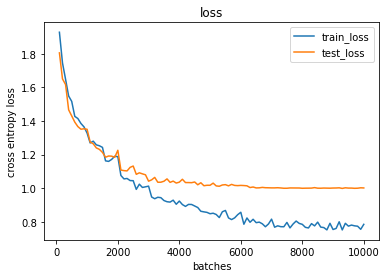

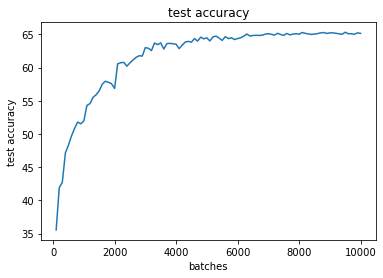

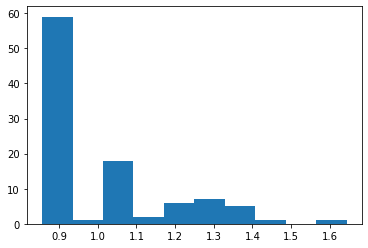

In [12]:
plot_loss(LeNN)
plot_acc(LeNN)

plt.hist(LeNN.train_time)
plt.show()

## CIFAR10 LeASLNet

In [13]:
# mock train_function of Optimizer to load the optimizer
ASL_train_function = None

with open('models/LeNet_Cifar/LeASLNet_optimizer.pkl', 'rb') as file:
    LeASLNet_optim = pickle.load(file)

parameters, acc= LeASLNet_optim.get_best_parameters()
print(parameters, acc)

{'lr': 0.026123046875, 'momentum': 0.928466796875, 'p_randomTransform': 0.00634765625} 70.484


In [17]:
from Models import LeASLNet

LeASLNN = LeASLNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["momentum"], weight_decay=0, device=device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─CSC_block: 2-5                    [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        108
│    │    └─Conv2d: 3-2                  [100, 16, 16, 16]         112
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─

In [18]:
PATH = "models/LeNet_Cifar/LeASLNet.pth"

if exists(PATH):
    LeASLNN = torch.load(PATH)
    LeASLNN.eval()

In [19]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeASLNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 1.961
test_loss: 1.761, test_accuracy: 36.87
[1,   200] train_loss: 1.705
test_loss: 1.659, test_accuracy: 40.18
[1,   300] train_loss: 1.623
test_loss: 1.548, test_accuracy: 43.69
[1,   400] train_loss: 1.539
test_loss: 1.537, test_accuracy: 44.16
[1,   500] train_loss: 1.489
test_loss: 1.469, test_accuracy: 46.97
[2,   100] train_loss: 1.435
test_loss: 1.443, test_accuracy: 48.53
[2,   200] train_loss: 1.428
test_loss: 1.389, test_accuracy: 49.77
[2,   300] train_loss: 1.358
test_loss: 1.391, test_accuracy: 49.72
[2,   400] train_loss: 1.345
test_loss: 1.316, test_accuracy: 52.56
[2,   500] train_loss: 1.335
test_loss: 1.311, test_accuracy: 52.45
[3,   100] train_loss: 1.252
test_loss: 1.303, test_accuracy: 53.58
[3,   200] train_loss: 1.286
test_loss: 1.286, test_accuracy: 53.4
[3,   300] train_loss: 1.246
test_loss: 1.271, test_accuracy: 54.9
[3,   400] train_loss: 1.246
test_loss: 1.250, test_accuracy: 55.43
[3,   500] train_loss: 1.233
test_loss: 1.289, tes

In [20]:
torch.save(LeASLNN, "./models/LeNet_Cifar/LeASLNet.pth")

In [21]:
LeASLNN = torch.load("./models/LeNet_Cifar/LeASLNet.pth")

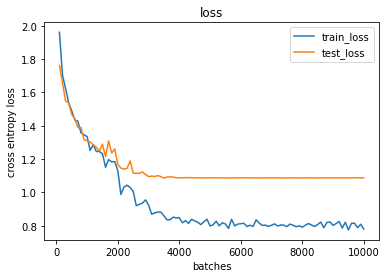

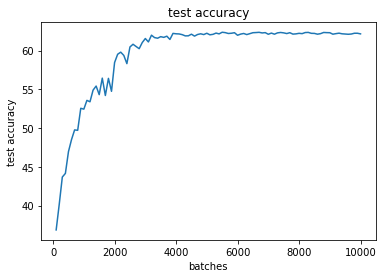

In [22]:
plot_loss(LeASLNN)
plot_acc(LeASLNN)

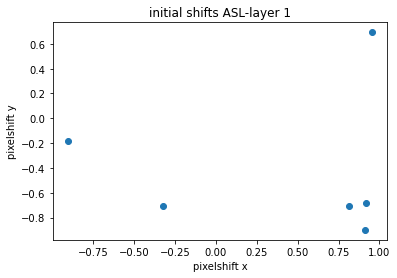

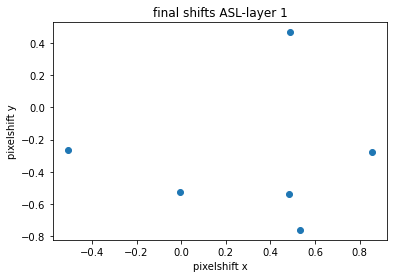

In [23]:
plot_shifts(LeASLNN)

## CIFAR10 LeDepthNet

In [ ]:
# mock train_function of Optimizer to load the optimizer
train_function = None

with open('models/LeNet_Cifar/LeDepthNet_optimizer.pkl', 'rb') as file:
    LeDepthNet_optim = pickle.load(file)

parameters, acc= LeDepthNet_optim.get_best_parameters()
print(parameters, acc)

In [26]:
from Models import LeDepthNet

LeDepthNN = LeDepthNet(input_shape, num_labels, initial_lr=parameters["lr"], momentum=parameters["msomentum"], weight_decay=0, device=device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 32, 32]          456
│    └─BatchNorm2d: 2-2                  [100, 6, 32, 32]          12
│    └─Tanh: 2-3                         [100, 6, 32, 32]          --
│    └─AvgPool2d: 2-4                    [100, 6, 16, 16]          --
│    └─Depth_wise_block: 2-5             [100, 16, 16, 16]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 16, 16]         --
│    └─AvgPool2d: 2-7                    [100, 16, 8, 8]           --
│    └─Flatten: 2-8                      [100, 1024]               --
│    └─Linear: 2-9                       [100, 120]                123,000
│    └─Tanh: 2-10                        [100, 120]                --
│    └─L

In [27]:
PATH = "models/LeNet_Cifar/LeDepthNet.pth"

if exists(PATH):
    LeDepthNN = torch.load(PATH)
    LeDepthNN.eval()

In [28]:
criterion = CrossEntropyLoss()
epochs = 20

train_NN(LeDepthNN, criterion, train_dataloader, test_dataloader, epochs=epochs, batches_to_test=100,
        patience=2,device=device, print_test=True, verbose=True, p_randomTransform=parameters["p_randomTransform"])

[1,   100] train_loss: 2.131
test_loss: 1.940, test_accuracy: 28.58
[1,   200] train_loss: 1.829
test_loss: 1.731, test_accuracy: 36.22
[1,   300] train_loss: 1.675
test_loss: 1.605, test_accuracy: 41.9
[1,   400] train_loss: 1.638
test_loss: 1.639, test_accuracy: 41.09
[1,   500] train_loss: 1.590
test_loss: 1.567, test_accuracy: 43.74
[2,   100] train_loss: 1.524
test_loss: 1.539, test_accuracy: 43.75
[2,   200] train_loss: 1.538
test_loss: 1.497, test_accuracy: 46.26
[2,   300] train_loss: 1.519
test_loss: 1.483, test_accuracy: 46.1
[2,   400] train_loss: 1.495
test_loss: 1.442, test_accuracy: 47.92
[2,   500] train_loss: 1.463
test_loss: 1.479, test_accuracy: 46.49
[3,   100] train_loss: 1.455
test_loss: 1.505, test_accuracy: 46.94
[3,   200] train_loss: 1.462
test_loss: 1.472, test_accuracy: 48.47
[3,   300] train_loss: 1.444
test_loss: 1.457, test_accuracy: 48.0
[3,   400] train_loss: 1.417
test_loss: 1.424, test_accuracy: 49.04
[3,   500] train_loss: 1.410
test_loss: 1.415, test

In [29]:
torch.save(LeDepthNN, "./models/LeNet_Cifar/LeDepthNet.pth")

In [ ]:
LeDepthNN = torch.load("./models/LeNet_Cifar/LeDepthNet.pth")

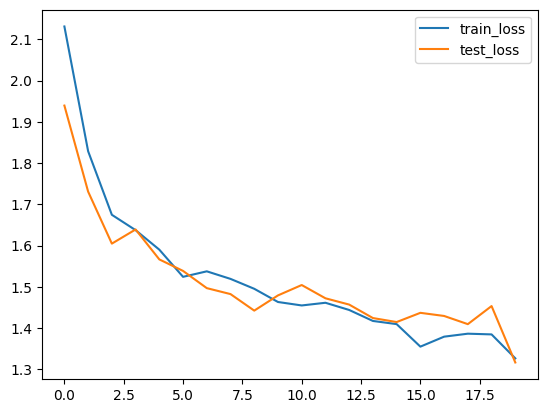

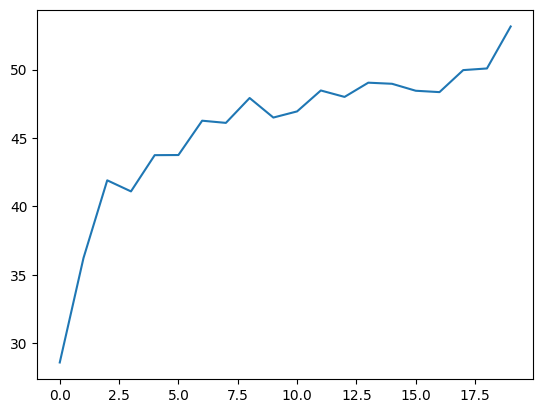

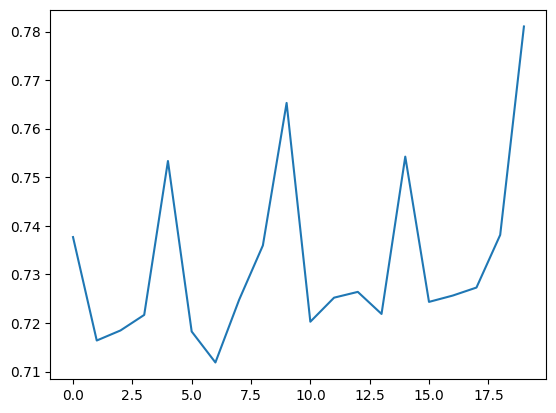

In [30]:
plot_loss(LeDepthNN)
plot_acc(LeDepthNN)

plt.hist(LeDepthNN.train_time)
plt.show()